In [48]:
import torch
import random
import os
import numpy as np
import pickle5 as pickle
from pathlib import Path
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
import albumentations as A
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from utils.dataloaders import MDSDataset, LipstickDataset, Birds_OneCluster, ACDCDataset, ShapeDataset, Birds_Dataset

### ACDC

In [121]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_set = ACDCDataset('/home/e_radionova/Datasets/ACDC/train.h5', device)
val_set = ACDCDataset('/home/e_radionova/Datasets/ACDC/val.h5', device)

### Birds one cluster

In [123]:
with open("/home/e_radionova/DeepCluster/deepcluster/checkpts_Birds_1500epochs_30cls/clusters", "rb") as f:
    clusters = pickle.load(f)

epoch = 1000 #-1
num_cluster = 3 #11
cluster_idxs = clusters[epoch][num_cluster]

In [124]:
def find_names_in_fold(prefix):
    images_names = np.sort(os.listdir(prefix))
    list_names = np.sort(os.listdir(prefix / images_names[0])).tolist()
    for i, x in enumerate(list_names):
        list_names[i] = os.path.join(images_names[0],x)
    for i in images_names[1:]:
        list_names_onefold = np.sort(os.listdir(prefix / i)).tolist()
        for j, x in enumerate(list_names_onefold):
            list_names_onefold[j] = os.path.join(i, x)
        list_names.extend(list_names_onefold)
    return list_names

In [127]:
dataset_path = Path('/home/e_radionova/Datasets/Caltech_birds/CUB_200_2011/dataset')
train_imgs_path = dataset_path /  'train/images/'
train_masks_path = dataset_path /  'train/masks/'

train_masks_names = find_names_in_fold(train_masks_path)
train_imgs_names = find_names_in_fold(train_imgs_path)

lst_cluster_masks = [train_masks_names[i] for i in cluster_idxs]
lst_cluster_imgs = [train_imgs_names[i] for i in cluster_idxs]

from sklearn.model_selection import train_test_split
train_imgs, test_imgs, train_masks, test_masks = train_test_split(lst_cluster_imgs, lst_cluster_masks, 
                                                                  test_size=0.3, random_state=42)

In [128]:
trans = transforms.Compose([
#     transforms.Resize((390, 390), interpolation=Image.NEAREST),
    transforms.CenterCrop((400, 400)),
    transforms.ToTensor(),
])

train_set = Birds_OneCluster(img_names = train_imgs, 
                             mask_names = train_masks, 
                             images_folder = dataset_path / 'train/images', 
                             masks_folder = dataset_path / 'train/masks',
                             clusters=None,
                             cluster_num=11,
                             cluster_epoch=-1, 
                             img_transform = trans, 
                             masks_transform = trans)

val_set = Birds_OneCluster(img_names = test_imgs, 
                           mask_names = test_masks,
                           images_folder = dataset_path / 'train/images',
                           masks_folder = dataset_path / 'train/masks',
                           clusters=None,
                           cluster_num=11,
                           cluster_epoch=-1, 
                           img_transform = trans,
                           masks_transform = trans)

### Birds full dataset

In [96]:
dataset_path = Path('/home/e_radionova/Datasets/Caltech_birds/CUB_200_2011')

In [120]:
trans = transforms.Compose([
#     transforms.Resize((390, 390)),
    transforms.CenterCrop((320, 320)),
    transforms.ToTensor(),
])

train_set = Birds_Dataset(images_folder = dataset_path / 'dataset/train/images', 
                         masks_folder = dataset_path / 'dataset/train/masks',
                         img_transform = trans,
                        masks_transform = trans)

val_set = Birds_Dataset(images_folder = dataset_path / 'dataset/test/images', 
                         masks_folder = dataset_path / 'dataset/test/masks',
                         img_transform = trans,
                      masks_transform = trans)

### Lipstick

In [20]:
dataset_path = Path('/home/e_radionova/Datasets/Lipstick')

In [21]:
trans = A.Compose([
    A.RandomCrop(width=640, height=640),
    A.Resize(256, 256),
    A.RandomRotate90(p=1),
#       A.HorizontalFlip(p=0.5),
#       A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.8),
                  ])

train_set = LipstickDataset(images_folder = dataset_path / 'dataset/train/imgs', 
                         masks_folder = dataset_path / 'dataset/train/masks',
                         transform = trans)

val_set = LipstickDataset(images_folder = dataset_path / 'dataset/val/imgs', 
                         masks_folder = dataset_path / 'dataset/val/masks',
                         transform = trans)

### Simple shapes

In [71]:
dataset_path = Path('/home/e_radionova/Datasets/SimpleShapes_10_classes')

In [90]:
trans = transforms.Compose([
#     transforms.Resize((390, 390), interpolation=Image.NEAREST),
    transforms.CenterCrop((300, 400)),
    transforms.ToTensor(),
])

train_set = ShapeDataset(images_folder = dataset_path / 'dataset/images', 
                         masks_folder = dataset_path / 'dataset/masks',
                         img_transform = trans,
                        masks_transform = trans)

val_set = ShapeDataset(images_folder = dataset_path / 'dataset/images', 
                         masks_folder = dataset_path / 'dataset/masks',
                         img_transform = trans,
                      masks_transform = trans)

### See data

In [121]:
image_datasets = {
    'train': train_set , 'val': val_set
}

batch_size_train = 16
batch_size_val = batch_size_train

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 5994, 'val': 5794}

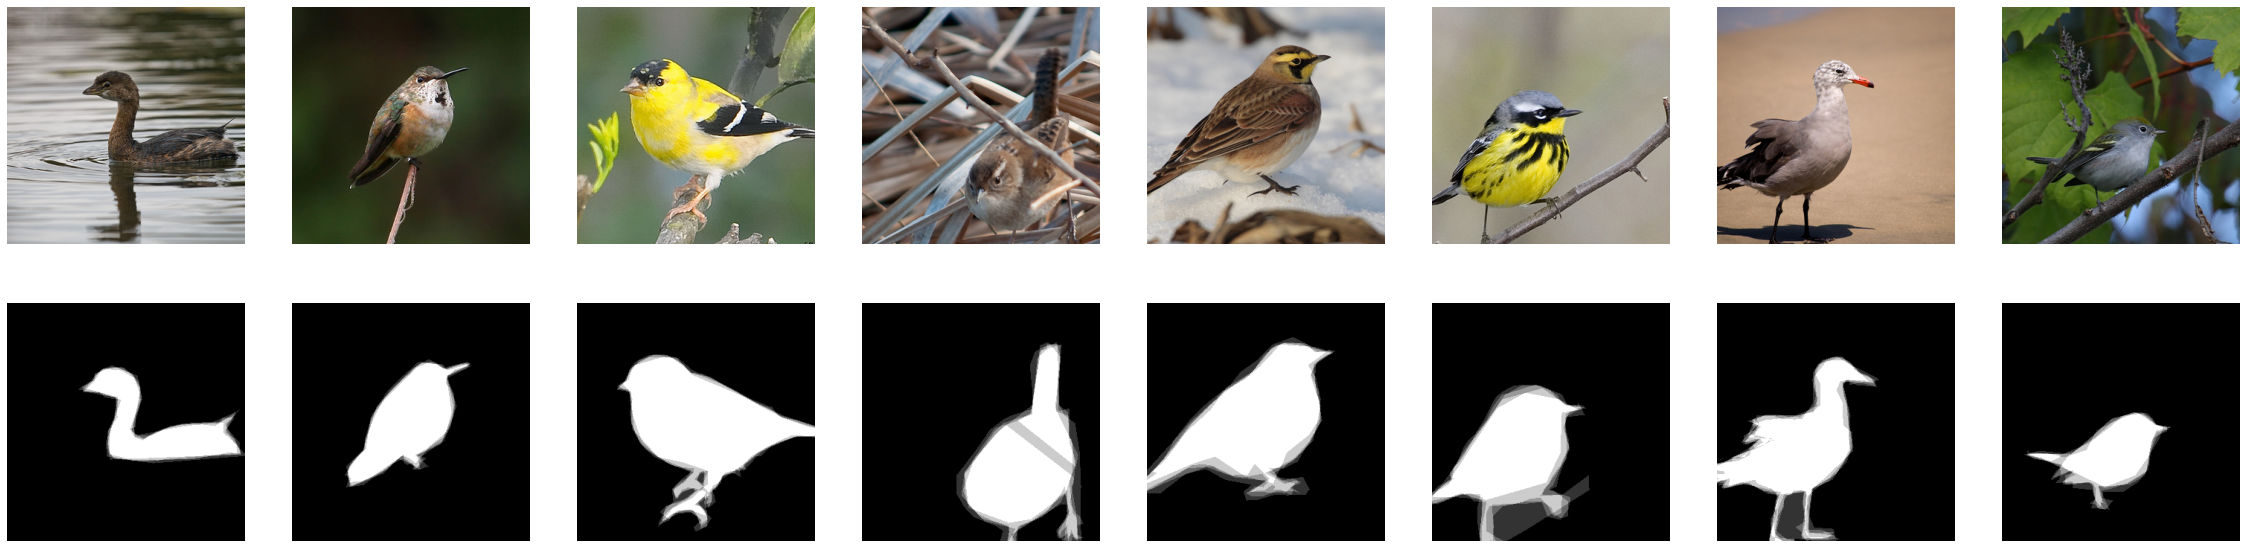

In [122]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

n_pics_to_show = 8
inputs, masks = next(iter(dataloaders['train']))
fig, ax = plt.subplots(2, n_pics_to_show, figsize=(40, 10))
for i in range(n_pics_to_show):
    pic, label = inputs[i], masks[i]
    label_np = label.data.numpy().transpose(1, 2, 0)
    pic_np = pic.data.numpy().transpose(1, 2, 0)
    ax[0,i].imshow(pic_np, cmap='gray')
    ax[0,i].axis('off')
    ax[1,i].imshow(label_np, cmap='gray')
    ax[1,i].axis('off')

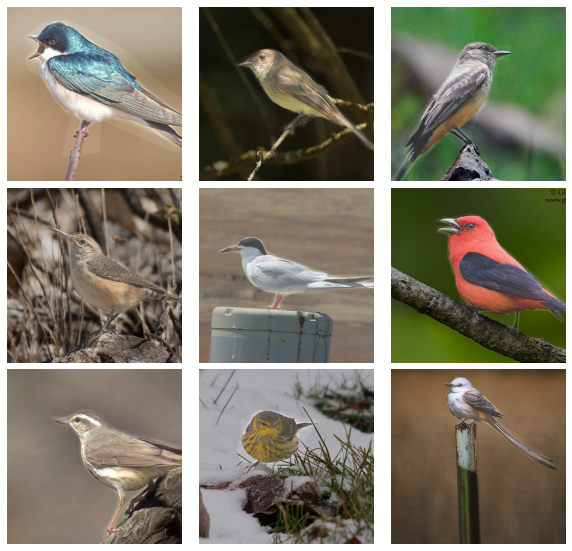

In [123]:
SEED = 37
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

n_pics_to_show = 9
half = int(n_pics_to_show/3)
inputs, masks = next(iter(dataloaders['train']))
fig, ax = plt.subplots(3, half, figsize=(10, 10))
plt.subplots_adjust(wspace=0.1,hspace=0.001)
for i in range(n_pics_to_show):
    pic, label = inputs[i], masks[i]
    label_np = label.data.numpy().transpose(1, 2, 0)
    pic_np = pic.data.numpy().transpose(1, 2, 0)
    ax[i//half, i%half].imshow(pic_np, cmap='gray')
    ax[i//half, i%half].imshow(label_np, cmap='gray', alpha=0.2)
    ax[i//half, i%half].axis('off')